In [1]:
# change directory
import os
rootdir = os.path.dirname(os.getcwd())
os.chdir(rootdir)

# import third libs for experiment
import logging as log
from mesa import batch_run
from benchmarks import schema as sch
from utils import constants as cst
from utils import rendering as vw
from config import DEFAULT_SEED

In [2]:
def simulate(algo_name, benchmark_id, db_type='MySql', filter_=None, seed=DEFAULT_SEED):
    modelcls = cst.MODELS[algo_name]
    dbcls = cst.DATABASES[db_type]
    verbose = False
    num_proc = 1
    level = log.DEBUG

    # create db connection
    db = dbcls(benchmark_id, verbose)
    session = db.connect()

    # find all problems
    Pb = sch.Problem
    query = session.query(Pb)
    if filter_:
        query = query.filter(Pb.name.like(filter_))
    problem_ids = [p.uid for p in query.all()]
    # pprint(problem_ids)

    # clear previous experiments with the same algorithm
    Exp = sch.Experiment
    query = session.query(Exp)
    query = query.filter(Exp.problem_id.in_(problem_ids))
    query = query.filter(Exp.model_name==algo_name)
    for exp in query.all():
        session.delete(exp)
    session.commit()

    # create new experiments
    model_name = algo_name
    Uid = Exp.next_uid
    experiment_ids = {}
    for problem_id in problem_ids:
        uid = Uid()
        experiment = Exp(uid=uid, problem_id=problem_id, model_name=model_name)
        # print('\t', experiment)
        session.add(experiment)
        experiment_ids[problem_id] = uid
    session.commit()

    # run experiments
    display = not verbose
    params = {'db_type':db_type, 'benchmark_id':benchmark_id, 
              'problem_id':problem_ids, 'verbose':verbose, 
              'seed':seed, 'log_level':level}
    results = batch_run(modelcls, params, number_processes=num_proc, display_progress=display)

    # save results
    metadata = ['RunId', 'iteration',  'benchmark_id', 'problem_id', 'db_type', 'verbose', 'seed']
    Stat = sch.Statistic
    # pprint(results)
    for result in results:
        problem_id = result['problem_id']
        exp_id = experiment_ids[problem_id]
        stats = [Stat(exp_id=exp_id, name=k, value=v) 
                 for k,v in result.items() 
                 if k not in metadata]
        session.add_all(stats)
        session.commit()
    
    # close db connection
    session.close()
    db.disconnect()

## Run small experiment with default method

In [3]:
algo_name = 'RCEMP-DIAL'
benchmark_id = 'Dialysis2021'
filter_ = '%m4'
simulate(algo_name, benchmark_id, filter_=filter_)

100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


In [4]:
dbmsid = 'MySql'
ganttview = vw.GanttView(benchmark_id, dbmsid)
ganttview

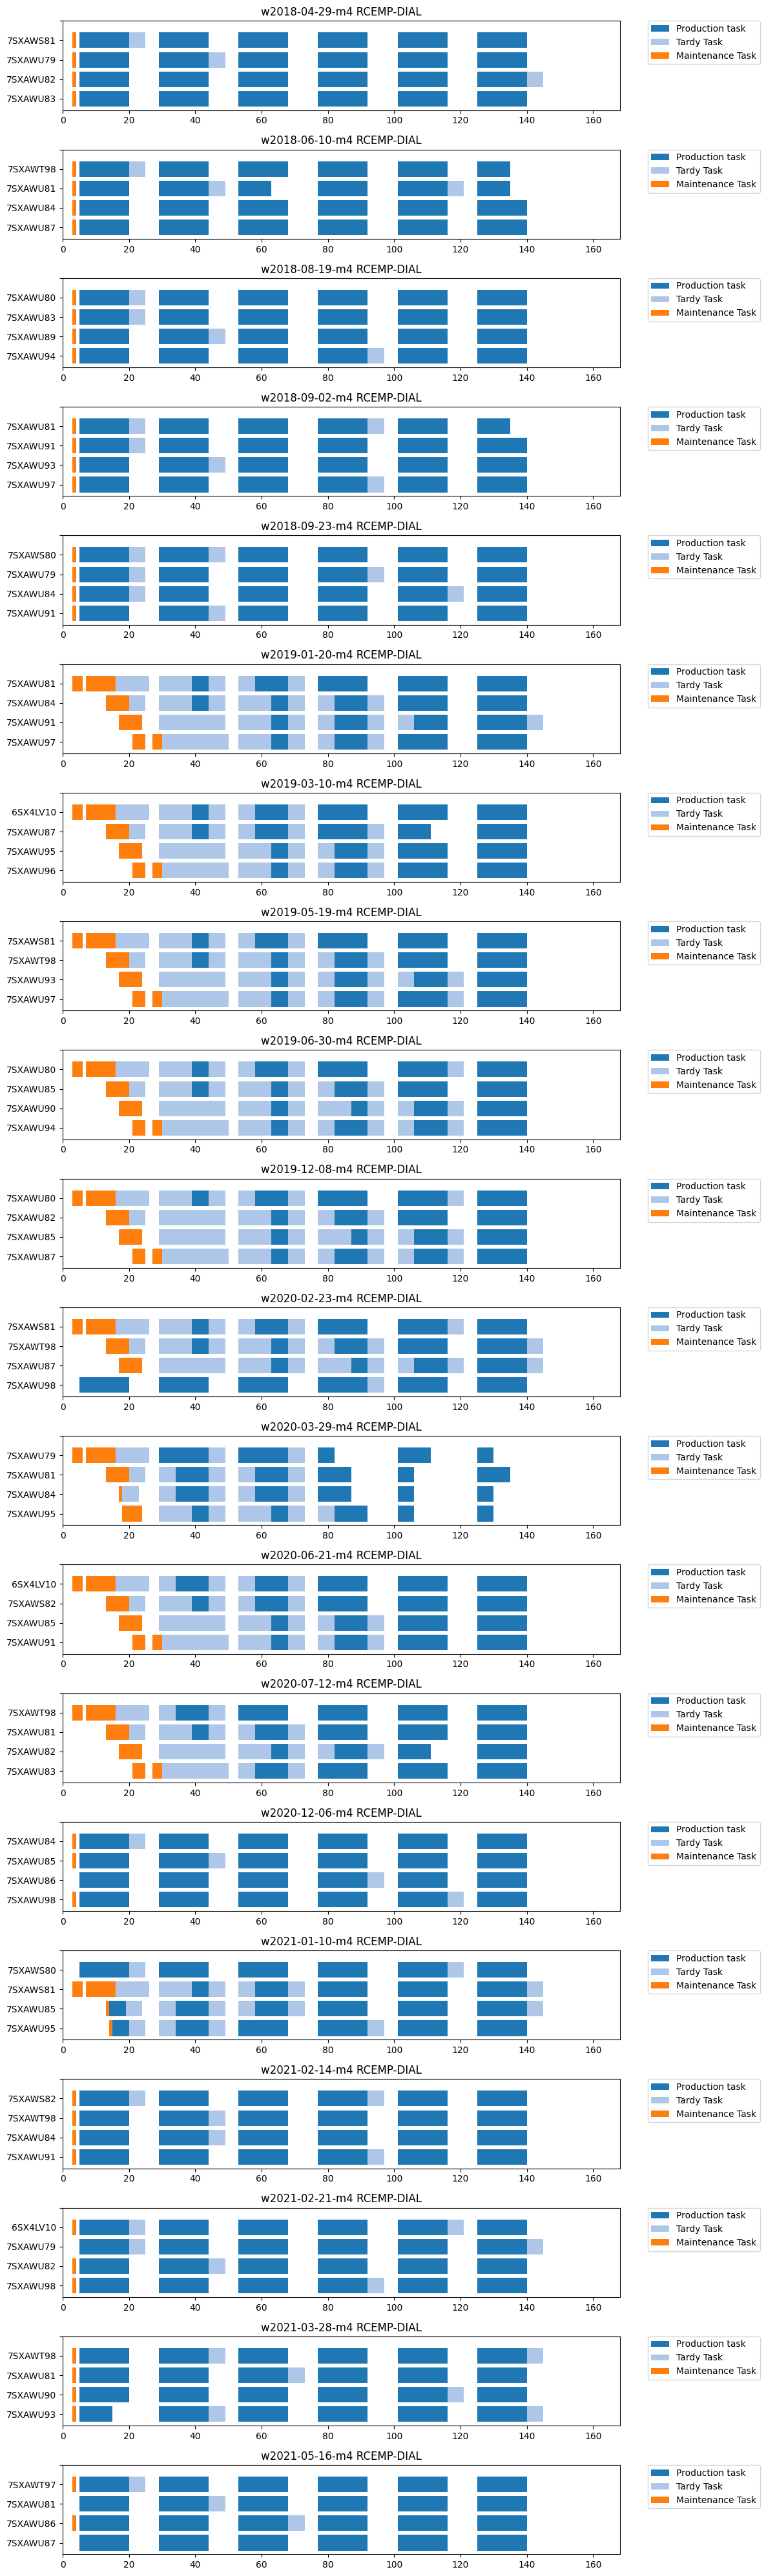

In [5]:
f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
ganttview.plot('%-m4', '%CEMP-DIAL', time_window=(0, 168), title_format=f)

In [6]:
filter_ = '%m4'
sql = f"""select p.name as problem_name, s.name as var_name, s.value 
                from statistics s, problems p, experiments e
                where s.exp_id = e.uid and e.problem_id = p.uid
                and e.model_name in ('RCEMP-DIAL')
                and s.name in ('s', 'R', 'nR')
                and p.name like '{filter_}'
                order by p.name, s.name, s.value;"""

In [7]:
statsview = vw.StatsView(benchmark_id, dbmsid)
data = statsview.load_results(sql)
data.head(25)

,problem_name,var_name,value
0,w2018-04-29-m4,nR,3.0
1,w2018-04-29-m4,R,15.0
2,w2018-04-29-m4,s,1.0
3,w2018-06-10-m4,nR,3.0
4,w2018-06-10-m4,R,15.0
5,w2018-06-10-m4,s,1.0
6,w2018-08-19-m4,nR,4.0
7,w2018-08-19-m4,R,20.0
8,w2018-08-19-m4,s,1.0
9,w2018-09-02-m4,nR,5.0


## Run big experiment with default method

In [8]:
algo_name = 'RCEMP-DIAL'
benchmark_id = 'Dialysis2021'
filter_ = '%m21'
simulate(algo_name, benchmark_id, filter_=filter_)

100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.38s/it]


In [9]:
dbmsid = 'MySql'
ganttview = vw.GanttView(benchmark_id, dbmsid)
ganttview

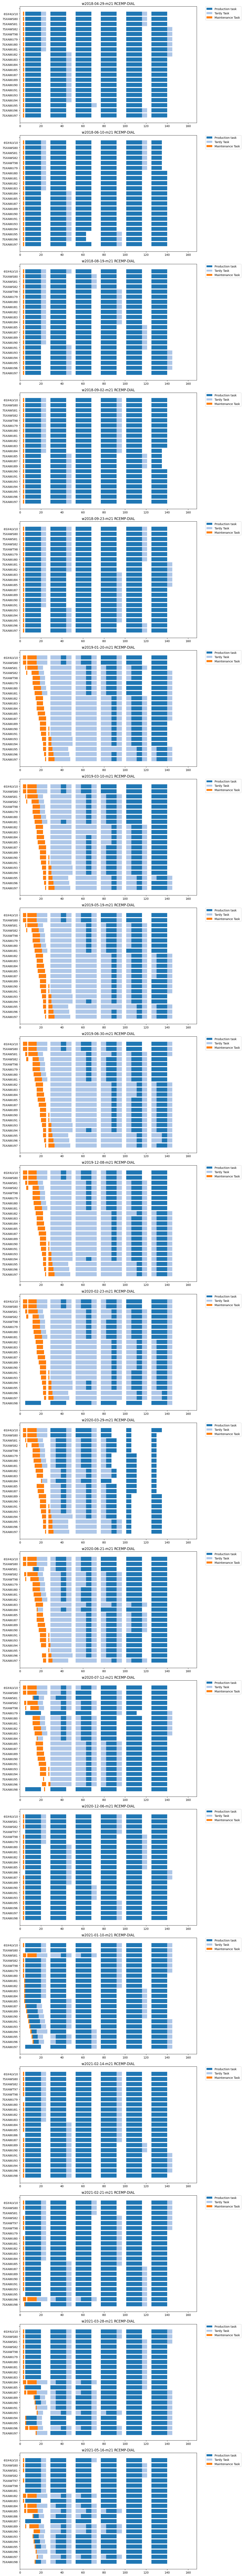

In [10]:
f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
ganttview.plot('%-m21', '%CEMP-DIAL', time_window=(0, 168), title_format=f)

In [11]:
filter_ = '%m21'
sql = f"""select p.name as problem_name, s.name as var_name, s.value 
                from statistics s, problems p, experiments e
                where s.exp_id = e.uid and e.problem_id = p.uid
                and e.model_name in ('RCEMP-DIAL')
                and s.name in ('s', 'R', 'nR')
                and p.name like '{filter_}'
                order by p.name, s.name, s.value;"""

In [12]:
statsview = vw.StatsView(benchmark_id, dbmsid)
data = statsview.load_results(sql)
data.head(25)

,problem_name,var_name,value
0,w2018-04-29-m21,nR,30.0
1,w2018-04-29-m21,R,150.0
2,w2018-04-29-m21,s,1.0
3,w2018-06-10-m21,nR,29.0
4,w2018-06-10-m21,R,145.0
5,w2018-06-10-m21,s,1.0
6,w2018-08-19-m21,nR,41.0
7,w2018-08-19-m21,R,205.0
8,w2018-08-19-m21,s,1.0
9,w2018-09-02-m21,nR,35.0
